## 模型介绍

1. 利用训练好的词向量构造句子


In [1]:
import keras 
from  os.path import join
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Lambda,Input,Merge,Flatten,Reshape,GlobalMaxPooling2D,MaxPooling2D
from keras.layers import Embedding
from keras.layers import Convolution1D
from keras.datasets import imdb
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D,Convolution2D,merge
from keras.utils import np_utils
from keras.models import Model
import numpy as np
from gensim.models import word2vec
from keras.regularizers import l2
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from keras.constraints import maxnorm
import pickle
import re
from keras.callbacks import EarlyStopping

Using Theano backend.
Using gpu device 0: GeForce GT 630 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)
/home/bruce/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## 数据预处理

In [2]:
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip() if TREC else string.strip().lower()
def clean_str_sst(string):
    """
    Tokenization/string cleaning for the SST dataset
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)   
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()

In [3]:
file_names = ['stsa.fine.test','stsa.fine.train','stsa.fine.dev']
file_path = '/home/bruce/data/sentiment/'
def read_file(fname=''):
    with open(join(file_path,fname)) as fr:
        lines = fr.readlines()
    lines = [clean_str(line) for line in lines]
    lables = [int(line[0:1]) for line in lines]
    words = [line[2:].split() for line in lines]
    return words,lables       
train_X,train_y = read_file(fname='stsa.fine.train')
test_X,test_y = read_file(fname='stsa.fine.test')
dev_X,dev_y = read_file(fname='stsa.fine.dev')
print('train_X 的数量：',len(train_X))
print('test_X 的数量：',len(test_X))
#print('dev_X 的数量：',len(dev_X))
print(train_X[0:2])
print(train_y[0:2])

train_X 的数量： 8544
test_X 的数量： 2210
[['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're', 'imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films'], ['apparently', 'reassembled', 'from', 'the', 'cutting', 'room', 'floor', 'of', 'any', 'given', 'daytime', 'soap']]
[4, 1]


## 句子长度统计信息

In [4]:
def statics_list2(arrays=[]):
    lengths=[]
    for array in arrays:
        lengths=lengths+[len(i) for i in array]
    wordset=set()
    for data in arrays:
        for sentence in data:
            wordset.update(sentence)
    print('total words :17836 /',len(wordset))
    lengths = sorted(lengths)
    length = len(lengths)
    #google_dict(filename='/home/bruce/data/google_word2vec/google_word2vec_300.txt',wordset=wordset)
    print('length = 11855 / ',len(lengths))
    print('max = ',lengths[-1])
    print('min =',lengths[0])
    print('average = ',sum(lengths)/length)
    
    print('top 50% = ',lengths[int(0.5*length)])
    print('top 80% = ',lengths[int(0.8*length)])
    print('top 90% = ',lengths[int(0.9*length)])
    print('top 95% = ',lengths[int(0.95*length)])
    
statics_list2(arrays=[train_X,test_X])

total words :17836 / 17087
length = 11855 /  10754
max =  53
min = 1
average =  18.372884508090014
top 50% =  18
top 80% =  26
top 90% =  31
top 95% =  35


In [5]:
def token_to_index(datas=[]):
    word_index={}
    count=1
    for data in datas:
        for sentence in data:
            for w in sentence:
                if w not in word_index:
                    word_index[w] = count
                    count = count + 1
    print('length of word_index =',len(word_index))
    for i in range(len(datas)):
        datas[i] = [[ word_index[w] for w in line ] for line in datas[i]] 
    return datas,word_index

In [6]:
X,word_index = token_to_index(datas=[train_X,test_X,dev_X])
train_X,test_X,dev_X= X
print(len(word_index))

length of word_index = 17833
17833


In [7]:
##验证：
print(train_X[0])
## 
index_word = dict([(kv[1],kv[0])for kv in word_index.items()])
sentence1 = [index_word[i] for i in train_X[0]]
sentence2 = [index_word[i] for i in train_X[-1]]
print(sentence1)
print(sentence2)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 5, 12, 13, 5, 14, 15, 16]
['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're', 'imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films']
['a', 'deliciously', 'nonsensical', 'comedy', 'about', 'a', 'city', 'coming', 'apart', 'at', 'its', 'seams']


## 加载训练好的Glove或者google词向量

In [8]:
word2vec_model = 'google'
embedding_dim = 300
#we_file = '/home/bruce/data/glove/twitter/glove.twitter.27B.{0}d.txt'.format(embedding_dim)
glove_w2v = '/home/bruce/data/glove/CommonCrawl/sst5_word_embedding_glove_dict.pkl'
google_w2v = '/home/bruce/data/google_word2vec/sst5_word_embedding_google_dict.pkl'

def get_index_embedding(word_index={}):
    count_in =0
    index_embedding ={}
    if word2vec_model == 'google':
        print('using google embedding')
        with open(google_w2v,'rb') as fr:
            word_embedding = pickle.load(fr)
    else:
        print('using glove embedding')
        with open(glove_w2v,'rb') as fr:
            word_embedding = pickle.load(fr)
    print('word_embedding size = ',len(word_embedding))
    for word,index in word_index.items():
        if word in word_embedding:
            count_in = count_in + 1
            index_embedding[index] = word_embedding[word]
        else:
            index_embedding[index] = np.random.uniform(-0.25,0.25,embedding_dim)
    print('pretrained word number :16262 / ',count_in)
    return index_embedding
index_embedding = get_index_embedding(word_index=word_index)
print('size of index_wordembedding = ',len(index_embedding))


using google embedding
word_embedding size =  16262
pretrained word number :16262 /  16262
size of index_wordembedding =  17833


In [9]:
def get_trained_embedding(index_wordembedding=None):
    index_we = sorted(index_wordembedding.items())
    trained_embedding = [t[1] for t in index_we]
    zeros = np.random.uniform(-0.25,0.25,embedding_dim)
    #zeros = np.zeros(embedding_dim)
    trained_embedding = np.vstack((zeros,trained_embedding))
    return np.array(trained_embedding)


## 构造模型

#### 参数

In [10]:
max_len = 56
batch_size=50

max_features = 17833 + 1

nb_filter = 100
dense1_hindden = 300
nb_classes = 5

## 二维卷积模型

In [11]:
input = Input(shape=(max_len,))
trained_embedding = get_trained_embedding(index_embedding)
print('trained_embedding shape = ',trained_embedding.shape)
embedding = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      weights=[trained_embedding]
                     )(input)
reshape = Reshape((1,max_len,embedding_dim))(embedding)
print('embedding dim = ',embedding_dim)
#卷积
conv2d_1 = Convolution2D(nb_filter,3,embedding_dim,border_mode='valid',activation='relu')
conv2d_2 = Convolution2D(nb_filter,4,embedding_dim,border_mode='valid',activation='relu')
conv2d_3 = Convolution2D(nb_filter,5,embedding_dim,border_mode='valid',activation='relu')
conv1 = conv2d_1(reshape)
conv2 = conv2d_2(reshape)
conv3 = conv2d_3(reshape)
maxpooling1 = MaxPooling2D(pool_size=(54,1))
maxpooling2 = MaxPooling2D(pool_size=(53,1))
maxpooling3 = MaxPooling2D(pool_size=(52,1))

pool1 = maxpooling1(conv1)
pool2 = maxpooling2(conv2)
pool3 = maxpooling3(conv3)

flat1 = Flatten()(pool1)
flat2 = Flatten()(pool2)
flat3 = Flatten()(pool3)
#print('maxpooling2 output shape = ',maxpooling2.output_shape)
#print('maxpooling3 output shape = ',maxpooling3.output_shape)
#merged_vector = merge([conv1,conv2,conv3], mode='concat')
mergelayer = Merge(mode='concat')
merged_vector = mergelayer([flat1,flat2,flat3])
dropout = Dropout(0.5)
drop_vector = dropout(merged_vector)
print('dropout input shape = ',dropout.input_shape)
print('dropout output shape = ',dropout.output_shape)

#全连接
output = Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3))(drop_vector)
#output = Dense(nb_classes,activation='softmax')(merged_vector)

print('dropout input shape (300,) = ',dropout.input_shape)
#softmax
model = Model(input=input,output=output)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1),
    #ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]

trained_embedding shape =  (17834, 300)
embedding dim =  300
dropout input shape =  (None, 300)
dropout output shape =  (None, 300)
dropout input shape (300,) =  (None, 300)


## Random 模型

In [ ]:
mode_in = Input(shape=(max_len,),dtype='int32')

embedding = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      input_length = max_len
                     )(mode_in)
print('embedding dim = ',embedding_dim)
#卷积
conv_result=[]
for i in range(3):
    conv = Convolution1D(nb_filter,3+i,border_mode='same',activation='relu')(embedding)
    pooling = GlobalMaxPooling1D()(conv)
    conv_result.append(pooling)
merge_layer = Merge(mode='concat')
merge_out = merge_layer(conv_result)
print('(None,{0}) = {1})'.format(3*nb_filter,merge_layer.output_shape))
#Dropout
merge_out = Dropout(0.5)(merge_out)
    
#softmax
mode_out = Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3))(merge_out)
    
#编译模型
model = Model(input=mode_in,output=mode_out)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1),
    #ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]

## static模型

In [94]:
mode_in = Input(shape=(max_len,),dtype='int32')
trained_embedding = get_trained_embedding(index_embedding)
print('trained_embedding shape = ',trained_embedding.shape)
embedding = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      input_length = max_len,
                      weights=[trained_embedding],
                      trainable=False
                     )(mode_in)
print('embedding dim = ',embedding_dim)
#卷积
conv_result=[]
for i in range(3):
    conv = Convolution1D(nb_filter,3+i,border_mode='same',activation='relu')(embedding)
    pooling = GlobalMaxPooling1D()(conv)
    conv_result.append(pooling)
merge_layer = Merge(mode='concat')
merge_out = merge_layer(conv_result)
print('(None,{0}) = {1})'.format(3*nb_filter,merge_layer.output_shape))
#Dropout
merge_out = Dropout(0.5)(merge_out)
    
#softmax
mode_out = Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3))(merge_out)
    
#编译模型
model = Model(input=mode_in,output=mode_out)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1),
    #ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]

trained_embedding shape =  (17834, 300)
embedding dim =  300
conv1d_3 input shape: (None,56,300)  = (None, 56, 300)
conv1d_3 output shape: (None,56,100)  = (None, 56, 100)
dropout input shape (None,300) =  (None, 300)


## non-static 模型

In [ ]:
mode_in = Input(shape=(max_len,),dtype='int32')
trained_embedding = get_trained_embedding(index_embedding)
print('trained_embedding shape = ',trained_embedding.shape)
embedding = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      input_length = max_len,
                      weights=[trained_embedding],
                     )(mode_in)
print('embedding dim = ',embedding_dim)
#卷积
conv_result=[]
for i in range(3):
    conv = Convolution1D(nb_filter,3+i,border_mode='same',activation='relu')(embedding)
    pooling = GlobalMaxPooling1D()(conv)
    conv_result.append(pooling)
merge_layer = Merge(mode='concat')
merge_out = merge_layer(conv_result)
print('(None,{0}) = {1})'.format(3*nb_filter,merge_layer.output_shape))
#Dropout
merge_out = Dropout(0.5)(merge_out)
    
#softmax
mode_out = Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3))(merge_out)
    
#编译模型
model = Model(input=mode_in,output=mode_out)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1),
    #ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]

## 多通道模型

In [ ]:
mode_in = Input(shape=(max_len,),dtype='int32')
trained_embedding = get_trained_embedding(index_embedding)
print('trained_embedding shape = ',trained_embedding.shape)

embedding_non_static = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      input_length = max_len,
                      weights=[trained_embedding],
                     )(mode_in)
embedding_static = Embedding(output_dim=embedding_dim,
                      input_dim=max_features,
                      input_length = max_len,
                      weights=[trained_embedding],
                      trainable=False
                     )(mode_in)

print('embedding dim = ',embedding_dim)
#卷积
conv_result=[]
for i in range(3):
    conv_layer = Convolution1D(nb_filter,3+i,border_mode='same',activation='relu')
    conv1 = conv_layer(embedding_static)
    conv2 = conv_layer(embedding_non_static)
    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    conv_result.append(pooling1)
    conv_result.append(pooling2)
merge_layer = Merge(mode='concat')
merge_out = merge_layer(conv_result)
print('(None,{0}) = {1})'.format(3*nb_filter,merge_layer.output_shape))
#Dropout
merge_out = Dropout(0.5)(merge_out)
    
#softmax
mode_out = Dense(nb_classes,activation='softmax',W_constraint = maxnorm(3))(merge_out)
    
#编译模型
model = Model(input=mode_in,output=mode_out)
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1),
    #ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]

## 模型图

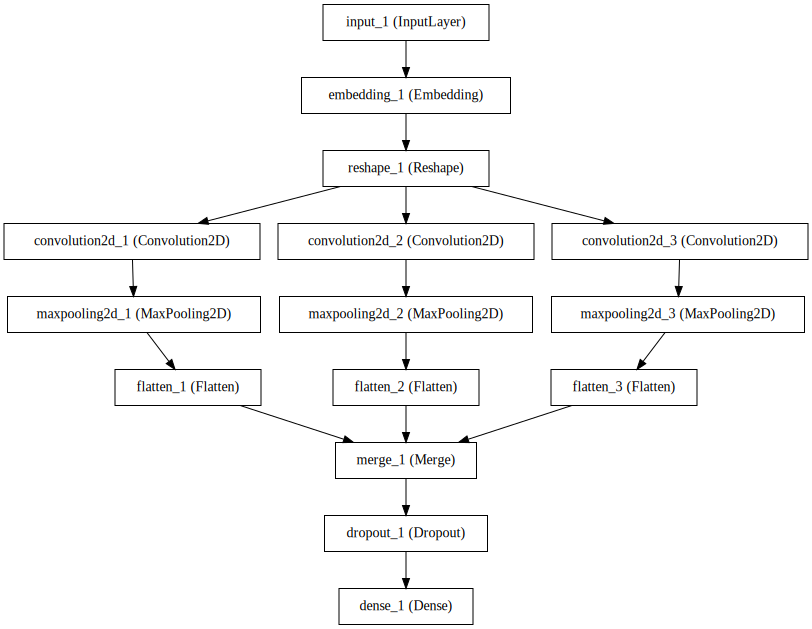

In [12]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 模型输入

In [13]:
print(type(train_y[0]))
train_y_model = np_utils.to_categorical(train_y, nb_classes)
#dev_y_model = np_utils.to_categorical(dev_y, nb_classes)
train_X_model = sequence.pad_sequences(train_X, maxlen=max_len)
#dev_X_model = sequence.pad_sequences(dev_X, maxlen=max_len)

<class 'int'>


In [14]:
#test 数据
#test_index_X= [[word_index[w] if w in word_index else 0 for w in line] for line in test_X]
test_index_X = test_X
test_X_model = sequence.pad_sequences(test_index_X,maxlen=max_len)
test_y_model = np_utils.to_categorical(test_y,nb_classes)

In [15]:
def shuffle(X,y):
    index=np.array(range(len(X)))
    np.random.shuffle(index)
    return X[index],y[index]
    

def my_generator(X=None,y=None):
    i = 0
    max_i = int(len(X)/batch_size)
    while True:
        i = i % max_i
        if i ==0:
            X,y = shuffle(X,y)
        x_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield (x_batch,y_batch)
        i = i + 1
    

In [99]:
print (model.layers)
print(model.layers[0].output_shape)
print(model.layers[1].input_shape)

[<keras.engine.topology.InputLayer object at 0x7f308327bb00>, <keras.layers.embeddings.Embedding object at 0x7f308327b128>, <keras.layers.convolutional.Convolution1D object at 0x7f30c4e33978>, <keras.layers.convolutional.Convolution1D object at 0x7f308327b4a8>, <keras.layers.convolutional.Convolution1D object at 0x7f30c4e33cc0>, <keras.layers.pooling.GlobalMaxPooling1D object at 0x7f30c6216550>, <keras.layers.pooling.GlobalMaxPooling1D object at 0x7f30c6216518>, <keras.layers.pooling.GlobalMaxPooling1D object at 0x7f30c6396cc0>, <keras.engine.topology.Merge object at 0x7f30c6396c50>, <keras.layers.core.Dropout object at 0x7f30c6396be0>, <keras.layers.core.Dense object at 0x7f30c63968d0>]
(None, 56)
(None, 56)


In [100]:
history_data = model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 40*100,nb_epoch=80,verbose=1,validation_data=(test_X_model,test_y_model))#history_data = model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 40*100,nb_epoch=50,verbose=1,validation_data=(test_X_model,test_y_model))

Epoch 1/80
4000/4000 [==============================] - 15s - loss: 1.5886 - acc: 0.2765 - val_loss: 1.5003 - val_acc: 0.3615
Epoch 2/80
4000/4000 [==============================] - 15s - loss: 1.5182 - acc: 0.3210 - val_loss: 1.4409 - val_acc: 0.3982
Epoch 3/80
4000/4000 [==============================] - 15s - loss: 1.4187 - acc: 0.3885 - val_loss: 1.3976 - val_acc: 0.4118
Epoch 4/80
4000/4000 [==============================] - 15s - loss: 1.3601 - acc: 0.4258 - val_loss: 1.3621 - val_acc: 0.4014
Epoch 5/80
4000/4000 [==============================] - 15s - loss: 1.2883 - acc: 0.4645 - val_loss: 1.3179 - val_acc: 0.4371
Epoch 6/80
4000/4000 [==============================] - 15s - loss: 1.2464 - acc: 0.4848 - val_loss: 1.3003 - val_acc: 0.4348
Epoch 7/80
4000/4000 [==============================] - 15s - loss: 1.1961 - acc: 0.5085 - val_loss: 1.2924 - val_acc: 0.4321
Epoch 8/80
4000/4000 [==============================] - 15s - loss: 1.1526 - acc: 0.5442 - val_loss: 1.2513 - val_acc:

In [16]:
history_data = model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 40*100,nb_epoch=80,verbose=1,validation_data=(test_X_model,test_y_model))#history_data = model.fit_generator(my_generator(train_X_model,train_y_model),samples_per_epoch = 40*100,nb_epoch=50,verbose=1,validation_data=(test_X_model,test_y_model))

Epoch 1/80
4000/4000 [==============================] - 12s - loss: 1.5362 - acc: 0.3030 - val_loss: 1.4823 - val_acc: 0.3443
Epoch 2/80
1950/4000 [=============>................] - ETA: 5s - loss: 1.4522 - acc: 0.3667

KeyboardInterrupt: 

In [ ]:
## 只有np.uniform(-0.25,0.25,k)
#Epoch 23/50 4000/4000 [==============================] - 12s - loss: 0.6418 - acc: 0.7897 - val_loss: 1.1927 - val_acc: 0.4796
#Epoch 30/70b 2000/2000 [==============================] - 7s - loss: 0.8755 - acc: 0.6840 - val_loss: 1.1844 - val_acc: 0.4778
## np.uniform(-0.25,0.25,k) ,dev数据，验证dev数据是否会影响算法。

## 

In [ ]:
print('test_X_model shape',test_X_model.shape)
history_data = model.fit(train_X_model,train_y_model,batch_size=50,nb_epoch=30,validation_data=(test_X_model,test_y_model))

test_X_model shape (2210, 56)
Train on 8544 samples, validate on 2210 samples
Epoch 1/30
  50/8544 [..............................] - ETA: 14s - loss: 1.4262 - acc: 0.2600

In [80]:
print('test_X_model shape',test_X_model.shape)
history_data = model.fit(train_X_model,train_y_model,batch_size=50,nb_epoch=30,validation_data=(test_X_model,test_y_model))
#history_data = model.fit(train_X_model,train_y_model,batch_size=50,nb_epoch=100,validation_data=(test_X_model,test_y_model),callbacks=callbacks)

test_X_model shape (2210, 56)
Train on 8544 samples, validate on 2210 samples
Epoch 1/30
1750/8544 [=====>........................] - ETA: 18s - loss: 0.0852 - acc: 0.9897

KeyboardInterrupt: 

In [ ]:
# 一维结果：
#Epoch 11/100 8544/8544 [==============================] - 31s - loss: 0.9243 - acc: 0.6465 - val_loss: 1.2593 - val_acc: 0.4570
#Epoch 18/100 8544/8544 [==============================] - 31s - loss: 0.5993 - acc: 0.8083 - val_loss: 1.3124 - val_acc: 0.4502
#Epoch 16/100 8544/8544 [==============================] - 31s - loss: 0.6924 - acc: 0.7590 - val_loss: 1.2710 - val_acc: 0.4480
#二维结果：
#Epoch 15/100 8544/8544 [==============================] - 25s - loss: 0.7123 - acc: 0.7480 - val_loss: 1.2520 - val_acc: 0.4629
#Epoch 13/100 8544/8544 [==============================] - 25s - loss: 0.8095 - acc: 0.6957 - val_loss: 1.2540 - val_acc: 0.4647
#Epoch 11/50 8544/8544 [==============================] - 25s - loss: 0.9090 - acc: 0.6598 - val_loss: 1.2291 - val_acc: 0.4724
#Epoch 25/50 4000/4000 [==============================] - 12s - loss: 0.8330 - acc: 0.6978 - val_loss: 1.2434 - val_acc: 0.4688


最佳测试成绩： 0.477828052384


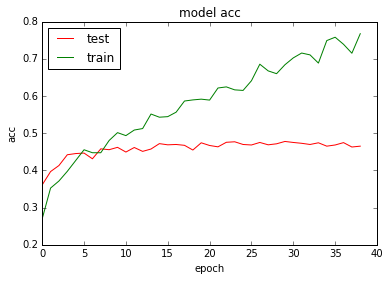

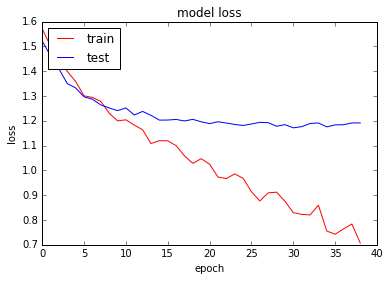

In [19]:
## non-sataic 动态测试
#glove
#Epoch 19/100 2000/2000 [==============================] - 8s - loss: 1.3439 - acc: 0.6145 - val_loss: 1.2428 - val_acc: 0.4629
#Epoch 38/100 2000/2000 [==============================] - 9s - loss: 0.5664 - acc: 0.9005 - val_loss: 1.4114 - val_acc: 0.4511
#Epoch 25/100 2000/2000 [==============================] - 9s - loss: 1.0709 - acc: 0.7110 - val_loss: 1.2304 - val_acc: 0.4661
#Epoch 38/100 2000/2000 [==============================] - 9s - loss: 0.5341 - acc: 0.9125 - val_loss: 1.6058 - val_acc: 0.4566
#Epoch 9/50 2000/2000 [==============================] - 9s - loss: 2.0732 - acc: 0.4635 - val_loss: 1.2695 - val_acc: 0.4597
#google 
#Epoch 54 2000/2000 [==============================] - 9s - loss: 0.6900 - acc: 0.8260 - val_loss: 1.3817 - val_acc: 0.4566
#Epoch 47/70 2000/2000 [==============================] - 9s - loss: 0.7923 - acc: 0.7745 - val_loss: 1.2870 - val_acc: 0.4620
#Epoch 27/100 4000/4000 [==============================] - 12s - loss: 0.6826 - acc: 0.7715 - val_loss: 1.2816 - val_acc: 0.4624
#最佳测试成绩： 0.469230768503
#google without drop
#Epoch 29/100 4000/4000 [==============================] - 12s - loss: 0.6389 - acc: 0.7812 - val_loss: 1.2826 - val_acc: 0.4584
#google without weights maxnorm
#Epoch 32/100 4000/4000 [==============================] - 12s - loss: 0.7241 - acc: 0.7467 - val_loss: 1.2620 - val_acc: 0.4633
#Epoch 22/100 4000/4000 [==============================] - 12s - loss: 0.9448 - acc: 0.6410 - val_loss: 1.2264 - val_acc: 0.4647
#Epoch 27/100 4000/4000 [==============================] - 12s - loss: 0.8440 - acc: 0.6878 - val_loss: 1.2288 - val_acc: 0.4652`
history = history_data.history
print('最佳测试成绩：',max(history['val_acc']))
fig = plt.figure()
plt.plot(history['val_acc'],'r')
plt.plot(history['acc'],'g',label='测试准确率')
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

fig = plt.figure()
plt.plot(history['loss'],color='r')
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
#static:
#最佳测试成绩： 0.453846151608
#epoch 18 2000/2000 [==============================] - 10s - loss: 1.3526 - acc: 0.6155 - val_loss: 1.2579 - val_acc: 0.4643
#epoch 23 2000/2000 [==============================] - 10s - loss: 1.0800 - acc: 0.6980 - val_loss: 1.2576 - val_acc: 0.4543
#epoch 26 2000/2000 [==============================] - 10s - loss: 0.9911 - acc: 0.7440 - val_loss: 1.3089 - val_acc: 0.4575
#Epoch 9/100 2000/2000 [==============================] - 10s - loss: 2.1036 - acc: 0.4565 - val_loss: 1.2884 - val_acc: 0.4552
#Epoch 23/40 2000/2000 [==============================] - 10s - loss: 1.0703 - acc: 0.7220 - val_loss: 1.2691 - val_acc: 0.4557
#Epoch 14/40 2000/2000 [==============================] - 5s - loss: 1.5780 - acc: 0.5405 - val_loss: 1.2548 - val_acc: 0.4570

print('最佳测试成绩：',max(history.test_accuracy))
fig = plt.figure()
plt.plot(history.test_accuracy,'r')
plt.plot(history.train_accuracy,'g',label='测试准确率')
plt.title('model loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

fig = plt.figure()
plt.plot(history.train_losses,color='r')
plt.plot(history.test_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# 实验结果

cnn-static:0.4489 ()
glove 300维度：0.4520
loss: 0.2594 - acc: 0.9935 - val_loss: 1.4543 - val_acc: 0.4575

cnn_non_static:
0.4498(loss=0.7727,acc=0.7438)
0.4643(loss=0.3920,acc = 0.9205)

 16s - loss: 0.5418 - acc: 0.9185 - val_loss: 1.3282 - val_acc: 0.4674
 loss: 0.7181 - acc: 0.8215 - val_loss: 1.2562 - val_acc: 0.4624